Setting refAnt: CS201HBA1
Loaded 58 antennas, 3595 times, 900 directions
Setting refAnt: CS201HBA0
Loaded 58 antennas, 3595 times, 900 directions
Setting refAnt: CS201HBA0
Setting refAnt: CS201HBA1
Setting refAnt: CS201HBA1
Using radio array Radio Array: 1.50000e+08 MHz, Longitude 6.84 deg Latitude 52.91 deg Height 30.97 m
Using phase center 217.62933909313728 deg 34.67457328431372 deg
Fixing frame at 2014-08-10T13:00:00.000
Elevation is 46.24627201340198 deg
Sun at zenith angle 40.729142650482565
Creating ionosphere model...
Found domain u in -145.51956720426597..143.7794388419452, v in -153.4459075376085..152.0603987286775, w in -102.87383524235211..1100.0
Nx=58 Ny=62 Nz=241 number of cells: 866636
Computing Cd over a window of 0.0 seconds
Spliting up jobs into directions


[========================================] 900/900 (100%)   0 to go 0.000000 sss
Completed in 123.77504889345619 seconds.


Creating ray cast job server
Submitting 900 ray cast jobs
Using straight line approximation
Waiting for ray cast jobs to finish.
Job execution statistics:
 job count | % of all jobs | job time sum | time per job | job server
       900 |        100.00 |     155.8482 |     0.173165 | local
Time elapsed since server creation 53.05698108673096
0 active tasks, 6 cores

Creating tec/Ct integration job server
Submitting 900 tec calculation jobs
Waiting for jobs to finish.
Job execution statistics:
 job count | % of all jobs | job time sum | time per job | job server
       900 |        100.00 |     254.2407 |     0.282490 | local
Time elapsed since server creation 75.2549033164978
0 active tasks, 6 cores

Size of muTCI cache: 20619
Computing dtec from tec products
Setting refAnt: CS201HBA1


C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


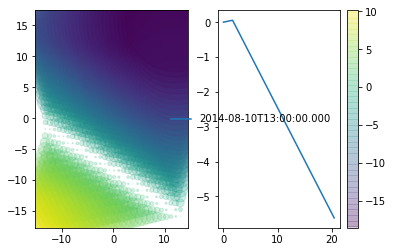

In [16]:
import astropy.units as au
import astropy.time as at
import astropy.coordinates as ac
import numpy as np
import pp
from time import clock
import pylab as plt
import h5py

from RealData import DataPack,plotDataPack
from FermatClass import Fermat
from PointingFrame import Pointing
from UVWFrame import UVW
from IRI import aPrioriModel, determineInversionDomain
from TricubicInterpolation import TriCubic
from ProgressBarClass import ProgressBar

def getDatumIdx(antIdx,timeIdx,dirIdx,numAnt,numTimes):
    '''standarizes indexing'''
    idx = antIdx + numAnt*(timeIdx + numTimes*dirIdx)
    return int(idx)

def getDatum(datumIdx,numAnt,numTimes):
    antIdx = datumIdx % numAnt
    timeIdx = (datumIdx - antIdx)/numAnt % numTimes
    dirIdx = (datumIdx - antIdx - numAnt*timeIdx)/numAnt/numTimes
    return int(antIdx),int(timeIdx),int(dirIdx)


def circ_conv(signal,kernel):
    return np.abs(np.real(np.fft.fft( np.fft.ifft(signal) * np.fft.ifft(kernel) )))


def simulatedTEC(dataPackObs,numThreads,datafolder,straightLineApprox=True,
                     antIdx=np.arange(10),timeIdx=[0],dirIdx=np.arange(10)):
    '''Invert the dtec in dataPack'''
    #Set up datafolder
    import os
    try:
        os.makedirs(datafolder)
    except:
        pass 
    #hyperparameters
    refAntIdx = 0
    zmax = 1000.
    L_ne,sigma_ne_factor = 20.,0.1
    def ppCastRay(origins, directions, neTCI, frequency, tmax, N, straightLineApprox):
        rays = ParallelInversionProducts.castRay(origins, directions, neTCI, frequency, tmax, N, straightLineApprox)
        return rays
    def ppCalculateTEC(rays, muTCI,K_e):
        tec,cache = ParallelInversionProducts.calculateTEC(rays, muTCI,K_e)
        return tec,cache
    def ppCalculateTEC_modelingError(rays, muTCI,K_e,sigma,frequency):
        tec,sigma_tec, cache = ParallelInversionProducts.calculateTEC_modelingError(rays, muTCI,K_e,sigma,frequency)
        return tec,sigma_tec, cache
    def ppInnovationPrimaryCalculation_exponential(rayPairs,muTCI,K_e,L_ne,sigma_ne_factor):
        outS_primary, cache = ParallelInversionProducts.innovationPrimaryCalculation_exponential(rayPairs,muTCI,K_e,L_ne,sigma_ne_factor)
        return outS_primary, cache
    def ppInnovationAdjointPrimaryCalculation_exponential(rays,muTCI,K_e,L_ne,sigma_ne_factor):
        outCmGt_primary, cache = ParallelInversionProducts.innovationAdjointPrimaryCalculation_exponential(rays,muTCI,K_e,L_ne,sigma_ne_factor)
        return outCmGt_primary, cache
    # get setup from dataPack
    dataPack = dataPackObs.clone()
    antennas,antennaLabels = dataPack.get_antennas(antIdx = antIdx)
    patches, patchNames = dataPack.get_directions(dirIdx=dirIdx)
    times,timestamps = dataPack.get_times(timeIdx=timeIdx)
    dataPackObs.setReferenceAntenna(antennaLabels[refAntIdx])
    dataPack.setReferenceAntenna(antennaLabels[refAntIdx])
    dataPackObs.save("{}/dataobs.hdf5".format(datafolder))
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    #Setting up ionosphere to use
    print("Using radio array {}".format(dataPack.radioArray))
    phase = dataPack.getCenterDirection()
    print("Using phase center {} {}".format(phase.ra,phase.dec))
    fixtime = times[Nt>>1]
    print("Fixing frame at {}".format(fixtime.isot))
    uvw = UVW(location = dataPack.radioArray.getCenter().earth_location,obstime = fixtime,phase = phase)
    print("Elevation is {}".format(uvw.elevation))
    zenith = dataPack.radioArray.getSunZenithAngle(fixtime)
    print("Sun at zenith angle {}".format(zenith))
    print("Creating ionosphere model...")
    xvec,yvec,zvec = determineInversionDomain(5.,antennas, patches,
                                              UVW(location = dataPack.radioArray.getCenter().earth_location,
                                                  obstime = fixtime, phase = phase), 
                                              zmax, padding = 20)
    X,Y,Z = np.meshgrid(xvec,yvec,zvec,indexing='ij')
    print("Nx={} Ny={} Nz={} number of cells: {}".format(len(xvec),len(yvec),len(zvec),np.size(X)))
    coords = ac.SkyCoord(X.flatten()*au.km,Y.flatten()*au.km,Z.flatten()*au.km,frame=uvw).transform_to('itrs').earth_location.to_geodetic('WGS84')
    heights = coords[2].to(au.km).value
    nePrior = aPrioriModel(heights,zenith).reshape(X.shape)
    nePert = nePrior.copy()
    #d layer
    nePert += 1e9*np.exp(-(X**2/15.**2 + (Y-25)**2/15.**2 + (Z-90)**2/10.**2)/2.)
    nePert += 5e9*np.exp(-((X+15)**2/15.**2 + (Y-10)**2/15.**2 + (Z-80)**2/10.**2)/2.)
    #elayer
    nePert += 1e10*np.exp(-(X**2/20.**2 + (Y+10)**2/20.**2 + (Z-110)**2/15.**2)/2.)
    nePert += 5e10*np.exp(-((X-35)**2/20.**2 + (Y+10)**2/20.**2 + (Z-105)**2/20.**2)/2.)
    #flayer
    nePert += 1e11*np.exp(-((X+10)**2/50.**2 + (Y-50)**2/50.**2 + (Z-300)**2/35.**2)/2.)
    nePert += 5e11*np.exp(-((X+25)**2/50.**2 + (Y+50)**2/50.**2 + (Z-250)**2/35.**2)/2.)
    nePert += 7e11*np.exp(-((X-35)**2/50.**2 + (Y+10)**2/50.**2 + (Z-400)**2/45.**2)/2.)
    
    nePert += 5e12*np.exp(-((X)**2/50.**2 + (Y)**2/50.**2 + (Z-400)**2/60.**2)/2.)
    
    neTCI = TriCubic(xvec,yvec,zvec,nePrior,useCache = True,default=None)
    neTCI.save("{}/apriori_neModel.hdf5".format(datafolder))
    neTCI = TriCubic(xvec,yvec,zvec,nePert,useCache = True,default=None)
    K_e = np.mean(neTCI.m)
    neMean = neTCI.m.copy()
    kSize = min(4,Nt)
    print("Computing Cd over a window of {} seconds".format(times[kSize-1].gps - times[0].gps))
    dobs = dataPackObs.get_dtec(antIdx = antIdx,dirIdx=dirIdx,timeIdx=timeIdx)
    kernel = np.zeros(Nt)
    kernel[0:kSize] = 1./kSize#flat
    Cd = np.zeros([Na,Nt,Nd])
    i = 0 
    while i < Na:
        k = 0
        while k < Nd:
            #Cd[i,:,k] = np.convolve(dobs[i,:,k]**2,kernel,mode='same') - np.convolve(dobs[i,:,k],kernel,mode='same')**2
            Cd[i,:,k] = circ_conv(dobs[i,:,k]**2,kernel)-(circ_conv(dobs[i,:,k],kernel))**2
            Cd[i,:,k] *= np.var(dobs[i,:,k])/(np.mean(Cd[i,:,k])+1e-15)
            k += 1
        #print("{}: dtec={} C_D={} C_T={} S/N={}".format(antennaLabels[i],dobs[i,:,0],Cd[i,:,0],Ct[i,:,0],dobs[i,:,0]/np.sqrt(Cd[i,:,0]+Ct[i,:,0])))
        i += 1
    Cd[np.isnan(Cd)] = 0.
    #np.save("{}/Cd.npy".format(datafolder),Cd)
    #divide by direction
    print("Spliting up jobs into directions")
    progress = ProgressBar(Nd, fmt=ProgressBar.FULL)
    batches = {}
    k = 0
    while k < Nd:
        origins = []
        directions = []
        patchDir = patches[k]
        j = 0
        while j < Nt:
            time = times[j]
            pointing = Pointing(location = dataPack.radioArray.getCenter().earth_location,
                                obstime = time, fixtime = fixtime, phase = phase)
            direction = patchDir.transform_to(pointing).cartesian.xyz.value.flatten()
            ants = antennas.transform_to(pointing).cartesian.xyz.to(au.km).value.transpose()
            origins.append(ants)
            i = 0
            while i < Na:
                directions.append(direction)
                i += 1
            j += 1
        batches[k] = {'origins':np.vstack(origins),
                      'directions':np.vstack(directions)}
        progress(k)
        k += 1
    #np.save("{}/origins_directions.npy".format(datafolder),batches)
    progress.done()
    jobs = {}
    print("Creating ray cast job server")
    job_server_raycast = pp.Server(numThreads, ppservers=())
    print("Submitting {} ray cast jobs".format(len(batches)))
    if straightLineApprox:
        print("Using straight line approximation")
    else:
        print("Using Fermats Principle")
    #get rays
    jobs = {}
    k = 0
    while k < Nd:
        job = job_server_raycast.submit(ppCastRay,
                       args=(batches[k]['origins'], batches[k]['directions'], neTCI, dataPack.radioArray.frequency, 
                             zmax, 100, straightLineApprox),
                       depfuncs=(),
                       modules=('ParallelInversionProducts',))
        jobs[k] = job
        k += 1
    print("Waiting for ray cast jobs to finish.")
    rays = {}
    k = 0
    while k < Nd:
        rays[k] = jobs[k]()
        k += 1
    job_server_raycast.print_stats()
    job_server_raycast.destroy()
    mu = np.log(neTCI.m/K_e)
    muTCI = neTCI.copy()
    muTCI.m = mu
    iteration = 0
    parmratios = []
    #Calculate TEC
    muTCI.clearCache()
    neTCI.m = K_e*np.exp(muTCI.m)
    neTCI.clearCache()
    neTCI.save("{}/neModel-{}.hdf5".format(datafolder,iteration))
    print("Creating tec/Ct integration job server")
    job_server_tec = pp.Server(numThreads, ppservers=())
    #plot rays
    #plotWavefront(neTCI,rays[0]+rays[1],save=False,saveFile=None,animate=False)
    print("Submitting {} tec calculation jobs".format(len(batches)))
    #get rays
    jobs = {}
    k = 0
    while k < Nd:
        job = job_server_tec.submit(ppCalculateTEC_modelingError,
                       args=(rays[k], muTCI, K_e,sigma_ne_factor,dataPack.radioArray.frequency),
                       depfuncs=(),
                       modules=('ParallelInversionProducts',))
        jobs[k] = job
        k += 1
    print("Waiting for jobs to finish.")
    dtec_threads = {}
    Ct_threads = {}
    k = 0
    while k < Nd:
        dtec_threads[k],Ct_threads[k],muCache = jobs[k]()  
        muTCI.cache.update(muCache)
        k += 1 
    job_server_tec.print_stats()
    job_server_tec.destroy()
    print("Size of muTCI cache: {}".format(len(muTCI.cache)))
    print("Computing dtec from tec products")
    #progress = ProgressBar(Nd, fmt=ProgressBar.FULL)
    dtec = np.zeros([Na,Nt,Nd],dtype=np.double)
    Ct = np.zeros([Na,Nt,Nd],dtype=np.double)
    k = 0
    while k < Nd:
        c = 0
        j = 0
        while j < Nt:
            i = 0
            while i < Na:
                dtec[i,j,k] = dtec_threads[k][c]
                Ct[i,j,k] = Ct_threads[k][c]
                c += 1
                i += 1
            j += 1
        #progress(k)
        k += 1
    #progress.done()
    dataPack.set_dtec(dtec,antIdx=antIdx,timeIdx=timeIdx, dirIdx=dirIdx,refAnt=None)
    dataPack.save("{}/dataPackSim.hdf5".format(datafolder))
    plotDataPack(dataPack,antIdx=antIdx,timeIdx=timeIdx, dirIdx=dirIdx)
    return dataPack

def plotTCI(datafolder="output/simulated",datapackFile = "dataPackSim.hdf5", neTCIFile='neModel-0.hdf5',antIdx=np.arange(10),timeIdx=np.arange(1),dirIdx=-1):
    from RealData import DataPack
    import numpy as np
    from TricubicInterpolation import TriCubic
    import pylab as plt
    dataPack = DataPack(filename="{}/{}".format(datafolder,datapackFile))
    antennas,antennaLabels = dataPack.get_antennas(antIdx = antIdx)
    patches, patchNames = dataPack.get_directions(dirIdx=dirIdx)
    times,timestamps = dataPack.get_times(timeIdx=timeIdx)
    dtec = dataPack.get_dtec(antIdx=np.arange(3),timeIdx=np.arange(1),dirIdx=-1)
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    #Setting up ionosphere to use
    print("Using radio array {}".format(dataPack.radioArray))
    phase = dataPack.getCenterDirection()
    print("Using phase center {} {}".format(phase.ra,phase.dec))
    fixtime = times[Nt>>1]
    print("Fixing frame at {}".format(fixtime.isot))
    uvw = UVW(location = dataPack.radioArray.getCenter().earth_location,obstime = fixtime,phase = phase)
    print("Elevation is {}".format(uvw.elevation))
    zenith = dataPack.radioArray.getSunZenithAngle(fixtime)
    print("Sun at zenith angle {}".format(zenith))
    
    ants_uvw = antennas.transform_to(uvw).cartesian.xyz.to(au.km).value.transpose()
    dirs_uvw = patches.transform_to(uvw).cartesian.xyz.value.transpose()
    
    #plt.hist(dtec.flatten(),bins=50)
    #plt.yscale('log')
    #plt.show()
    neTCI = TriCubic(filename="{}/{}".format(datafolder,neTCIFile))
    import os
    try:
        os.makedirs("{}/figs".format(datafolder))
    except:
        pass 
    xvec = neTCI.xvec
    yvec = neTCI.yvec
    zvec = neTCI.zvec

    M = neTCI.getShapedArray()
    #plt.hist(np.log10(M).flatten(),bins=100)
    #plt.show()
    Nz = len(zvec)
    vmin = 8.
    vmax = np.max(np.log10(M))*1.2
    levels = np.linspace(vmin,vmax,15)
    for i in range(Nz):
        Z = np.log10(M[:,:,i])
        im = plt.imshow(Z,origin='lower',vmin=vmin,vmax=vmax,extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.bone)
        plt.colorbar(im,orientation='horizontal',label=r'$\log_{10} n_e[\mathrm{m}^{-3}])$',shrink=0.8)
        CS = plt.contour(Z, levels,
                     origin='lower',
                     linewidths=2,
                     extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.hot_r)
        zc = CS.collections[-1]
        plt.setp(zc, linewidth=4)

        plt.clabel(CS, levels[1::2],  # label every second level
                   inline=1,
                   fmt='%1.1f',
                   fontsize=14)

        CB = plt.colorbar(CS, shrink=0.8, extend='both')
        pir_u = np.add.outer(ants_uvw[:,0],dirs_uvw[:,0]/dirs_uvw[:,2]*zvec[i]).flatten()
        pir_v = np.add.outer(ants_uvw[:,1],dirs_uvw[:,1]/dirs_uvw[:,2]*zvec[i]).flatten()
        plt.scatter(pir_u,pir_v,marker='.',c='red',lw=1)

        plt.title("Distance {:.2f} km".format(zvec[i]))
        plt.xlabel('U km')
        plt.ylabel('V km')
        plt.savefig("{}/figs/slice-{:04d}.png".format(datafolder,i),format='png')
        plt.clf()

    os.system("ffmpeg.exe -framerate {} -i {}/figs/slice-%04d.png {}/figs/movie.mp4".format(int(Nz/10.),datafolder,datafolder))

def weightTCI(datafolder="output/simulated",datapackFile = "dataPackSim.hdf5", aPrioriFile = 'apriori_neModel.hdf5',neTCIFile='neModel-0.hdf5',antIdx=np.arange(10),timeIdx=np.arange(1),dirIdx=-1):
    from RealData import DataPack
    import numpy as np
    from TricubicInterpolation import TriCubic
    import pylab as plt
    dataPack = DataPack(filename="{}/{}".format(datafolder,datapackFile))
    antennas,antennaLabels = dataPack.get_antennas(antIdx = antIdx)
    patches, patchNames = dataPack.get_directions(dirIdx=dirIdx)
    times,timestamps = dataPack.get_times(timeIdx=timeIdx)
    dtec = dataPack.get_dtec(antIdx=np.arange(3),timeIdx=np.arange(1),dirIdx=-1)
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    #Setting up ionosphere to use
    print("Using radio array {}".format(dataPack.radioArray))
    phase = dataPack.getCenterDirection()
    print("Using phase center {} {}".format(phase.ra,phase.dec))
    fixtime = times[Nt>>1]
    print("Fixing frame at {}".format(fixtime.isot))
    uvw = UVW(location = dataPack.radioArray.getCenter().earth_location,obstime = fixtime,phase = phase)
    print("Elevation is {}".format(uvw.elevation))
    zenith = dataPack.radioArray.getSunZenithAngle(fixtime)
    print("Sun at zenith angle {}".format(zenith))
    
    ants_uvw = antennas.transform_to(uvw).cartesian.xyz.to(au.km).value.transpose()
    dirs_uvw = patches.transform_to(uvw).cartesian.xyz.value.transpose()
    
    #plt.hist(dtec.flatten(),bins=50)
    #plt.yscale('log')
    #plt.show()
    neTCI = TriCubic(filename="{}/{}".format(datafolder,neTCIFile))
    apneTCI = TriCubic(filename="{}/{}".format(datafolder,aPrioriFile))
    
    import os
    try:
        os.makedirs("{}/figs".format(datafolder))
    except:
        pass 
    xvec = neTCI.xvec
    yvec = neTCI.yvec
    zvec = neTCI.zvec
    Nz = len(zvec)

    M = neTCI.getShapedArray()
    apM = apneTCI.getShapedArray()
    # do weighting
    X,Y = np.meshgrid(xvec,yvec,indexing='ij')
    X_ = X.flatten()
    Y_ = Y.flatten()
    solM = apM.copy()
    for i in range(Nz):
        pir_u = np.add.outer(ants_uvw[:,0],dirs_uvw[:,0]/dirs_uvw[:,2]*zvec[i]).flatten()
        pir_v = np.add.outer(ants_uvw[:,1],dirs_uvw[:,1]/dirs_uvw[:,2]*zvec[i]).flatten()
        
        weight = np.sum(np.exp(-(np.subtract.outer(X_,pir_u)**2 + np.subtract.outer(Y_,pir_v)**2)/7.5**2/2.),axis=1).reshape(X.shape)
        med = np.median(weight[weight>np.mean(weight)])
        weight[weight>5] = 5.
        weight /= np.max(weight)
        solM[:,:,i] = solM[:,:,i]*(1-weight) + weight*M[:,:,i]
        im = plt.imshow(weight,origin='lower',vmin=0,vmax=1,extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.bone)
        plt.colorbar(im,orientation='horizontal',label=r'$\log_{10} n_e[\mathrm{m}^{-3}])$',shrink=0.8)
        plt.scatter(pir_u,pir_v,marker='.',c='red',lw=1)
        plt.title("Distance {:.2f} km".format(zvec[i]))
        plt.xlabel('U km')
        plt.ylabel('V km')
        plt.savefig("{}/figs/weight-{:04d}.png".format(datafolder,i),format='png')
        plt.clf()
    os.system("ffmpeg.exe -framerate {} -i {}/figs/weight-%04d.png {}/figs/weight-movie.mp4".format(int(Nz/10.),datafolder,datafolder))

    
    #plt.hist(np.log10(M).flatten(),bins=100)
    #plt.show()
    
    vmin = 8.
    vmax = np.max(np.log10(solM))*1.2
    levels = np.linspace(vmin,vmax,15)
    for i in range(Nz):
        Z = np.log10(solM[:,:,i])
        im = plt.imshow(Z,origin='lower',vmin=vmin,vmax=vmax,extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.bone)
        plt.colorbar(im,orientation='horizontal',label=r'$\log_{10} n_e[\mathrm{m}^{-3}])$',shrink=0.8)
        CS = plt.contour(Z, levels,
                     origin='lower',
                     linewidths=2,
                     extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.hot_r)
        zc = CS.collections[-1]
        plt.setp(zc, linewidth=4)

        plt.clabel(CS, levels[1::2],  # label every second level
                   inline=1,
                   fmt='%1.1f',
                   fontsize=14)

        CB = plt.colorbar(CS, shrink=0.8, extend='both')
        pir_u = np.add.outer(ants_uvw[:,0],dirs_uvw[:,0]/dirs_uvw[:,2]*zvec[i]).flatten()
        pir_v = np.add.outer(ants_uvw[:,1],dirs_uvw[:,1]/dirs_uvw[:,2]*zvec[i]).flatten()
        plt.scatter(pir_u,pir_v,marker='.',c='red',lw=1)

        plt.title("Distance {:.2f} km".format(zvec[i]))
        plt.xlabel('U km')
        plt.ylabel('V km')
        plt.savefig("{}/figs/slice-{:04d}.png".format(datafolder,i),format='png')
        plt.clf()

    os.system("ffmpeg.exe -framerate {} -i {}/figs/slice-%04d.png {}/figs/movie.mp4".format(int(Nz/10.),datafolder,datafolder))


def allTCI(datafolder="output/simulated",datapackFile = "dataPackSim.hdf5", aPrioriFile = 'apriori_neModel.hdf5',neTCIFile='neModel-0.hdf5',antIdx=np.arange(10),timeIdx=np.arange(1),dirIdx=-1):
    from RealData import DataPack
    import numpy as np
    from TricubicInterpolation import TriCubic
    import pylab as plt
    dataPack = DataPack(filename="{}/{}".format(datafolder,datapackFile))
    antennas,antennaLabels = dataPack.get_antennas(antIdx = antIdx)
    patches, patchNames = dataPack.get_directions(dirIdx=dirIdx)
    times,timestamps = dataPack.get_times(timeIdx=timeIdx)
    dtec = dataPack.get_dtec(antIdx=np.arange(3),timeIdx=np.arange(1),dirIdx=-1)
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    #Setting up ionosphere to use
    print("Using radio array {}".format(dataPack.radioArray))
    phase = dataPack.getCenterDirection()
    print("Using phase center {} {}".format(phase.ra,phase.dec))
    fixtime = times[Nt>>1]
    print("Fixing frame at {}".format(fixtime.isot))
    uvw = UVW(location = dataPack.radioArray.getCenter().earth_location,obstime = fixtime,phase = phase)
    print("Elevation is {}".format(uvw.elevation))
    zenith = dataPack.radioArray.getSunZenithAngle(fixtime)
    print("Sun at zenith angle {}".format(zenith))
    
    ants_uvw = antennas.transform_to(uvw).cartesian.xyz.to(au.km).value.transpose()
    dirs_uvw = patches.transform_to(uvw).cartesian.xyz.value.transpose()
    
    #plt.hist(dtec.flatten(),bins=50)
    #plt.yscale('log')
    #plt.show()
    neTCI = TriCubic(filename="{}/{}".format(datafolder,neTCIFile))
    apneTCI = TriCubic(filename="{}/{}".format(datafolder,aPrioriFile))
    
    import os
    try:
        os.makedirs("{}/figs".format(datafolder))
    except:
        pass 
    xvec = neTCI.xvec
    yvec = neTCI.yvec
    zvec = neTCI.zvec
    Nz = len(zvec)

    M = neTCI.getShapedArray()
    apM = apneTCI.getShapedArray()
    # do weighting
    X,Y = np.meshgrid(xvec,yvec,indexing='ij')
    X_ = X.flatten()
    Y_ = Y.flatten()
    solM = apM.copy()
    weights = apM.copy()*0.
    for i in range(Nz):
        pir_u = np.add.outer(ants_uvw[:,0],dirs_uvw[:,0]/dirs_uvw[:,2]*zvec[i]).flatten()
        pir_v = np.add.outer(ants_uvw[:,1],dirs_uvw[:,1]/dirs_uvw[:,2]*zvec[i]).flatten()
        
        
        weight = np.sum(np.exp(-(np.subtract.outer(X_,pir_u)**2 + np.subtract.outer(Y_,pir_v)**2)/7.5**2/2.),axis=1).reshape(X.shape)
        med = np.median(weight[weight>np.mean(weight)])
        weight[weight>5] = 5.
        weight /= np.max(weight)
        solM[:,:,i] = solM[:,:,i]*(1-weight) + weight*M[:,:,i]
        solM[:,:,i] += weight*0.05*solM[:,:,i]*np.random.normal(size=np.size(X)).reshape(X.shape)
        weights[:,:,i] = weight
        
        
    
    #plt.hist(np.log10(M).flatten(),bins=100)
    #plt.show()
    
    vmin = 8.
    vmax = np.max(np.log10(M))*1.2
    levels = np.linspace(vmin,vmax,15)
    for i in range(Nz):
        pir_u = np.add.outer(ants_uvw[:,0],dirs_uvw[:,0]/dirs_uvw[:,2]*zvec[i]).flatten()
        pir_v = np.add.outer(ants_uvw[:,1],dirs_uvw[:,1]/dirs_uvw[:,2]*zvec[i]).flatten()
        
        f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
        
        Z = np.log10(apM[:,:,i])
        ax = ax1
        im = ax.imshow(Z,origin='lower',vmin=vmin,vmax=vmax,extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.bone)
        #plt.colorbar(im,orientation='horizontal',label=r'$\log_{10} n_e[\mathrm{m}^{-3}])$',shrink=0.8)
        CS = ax.contour(Z, levels,
                     origin='lower',
                     linewidths=2,
                     extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.hot_r)
        zc = CS.collections[-1]
        plt.setp(zc, linewidth=4)
        plt.clabel(CS, levels[1::2],  # label every second level
                   inline=1,
                   fmt='%1.1f',
                   fontsize=14)
        #CB = plt.colorbar(CS, shrink=0.8, extend='both')
        ax.scatter(pir_u,pir_v,marker='.',c='red',lw=1)
        ax.set_title("a priori {:.2f} km".format(zvec[i]))
        ax.set_xlabel('U km')
        ax.set_ylabel('V km')
        
        Z = np.log10(M[:,:,i])
        ax = ax2
        im = ax.imshow(Z,origin='lower',vmin=vmin,vmax=vmax,extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.bone)
        #plt.colorbar(im,orientation='horizontal',label=r'$\log_{10} n_e[\mathrm{m}^{-3}])$',shrink=0.8)
        CS = ax.contour(Z, levels,
                     origin='lower',
                     linewidths=2,
                     extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.hot_r)
        zc = CS.collections[-1]
        plt.setp(zc, linewidth=4)
        plt.clabel(CS, levels[1::2],  # label every second level
                   inline=1,
                   fmt='%1.1f',
                   fontsize=14)
        #CB = plt.colorbar(CS, shrink=0.8, extend='both')
        ax.scatter(pir_u,pir_v,marker='.',c='red',lw=1)
        ax.set_title("True EC")
        ax.set_xlabel('U km')
        ax.set_ylabel('V km')
        
        Z = np.log10(solM[:,:,i])
        ax = ax3
        im = ax.imshow(Z,origin='lower',vmin=vmin,vmax=vmax,extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.bone)
        #plt.colorbar(im,orientation='horizontal',label=r'$\log_{10} n_e[\mathrm{m}^{-3}])$',shrink=0.8)
        CS = ax.contour(Z, levels,
                     origin='lower',
                     linewidths=2,
                     extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.hot_r)
        zc = CS.collections[-1]
        plt.setp(zc, linewidth=4)
        plt.clabel(CS, levels[1::2],  # label every second level
                   inline=1,
                   fmt='%1.1f',
                   fontsize=14)
        #CB = plt.colorbar(CS, shrink=0.8, extend='both')
        ax.scatter(pir_u,pir_v,marker='.',c='red',lw=1)
        ax.set_title("Solution")
        ax.set_xlabel('U km')
        ax.set_ylabel('V km')
        
        Z = weights[:,:,i]
        ax = ax4
        im = ax.imshow(Z,origin='lower',vmin=0,vmax=1,extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.bone)
        #plt.colorbar(im,orientation='horizontal',label=r'$\log_{10} n_e[\mathrm{m}^{-3}])$',shrink=0.8)
        #CS = ax.contour(Z, levels,
        #             origin='lower',
        #             linewidths=2,
        #             extent=[xvec[0],xvec[-1],yvec[0],yvec[-1]],cmap=plt.cm.hot_r)
        #zc = CS.collections[-1]
        #plt.setp(zc, linewidth=4)
        #plt.clabel(CS, levels[1::2],  # label every second level
        #           inline=1,
        #           fmt='%1.1f',
        #           fontsize=14)
        #CB = plt.colorbar(CS, shrink=0.8, extend='both')
        ax.scatter(pir_u,pir_v,marker='.',c='red',lw=1)
        ax.set_title("Adjoint")
        ax.set_xlabel('U km')
        ax.set_ylabel('V km')
        
        plt.savefig("{}/figs/solution-{:04d}.png".format(datafolder,i),format='png')
        plt.clf()

    os.system('ffmpeg.exe -framerate {} -i {}/figs/solution-%04d.png -vf scale="trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -profile:v high -pix_fmt yuv420p -g 30 -r 30 {}/figs/solution-movie.mp4'.format(int(Nz/10.),datafolder,datafolder))


if __name__ == '__main__':
    from RealData import prepareDataPack,DataPack
    antIdx = np.arange(45)[1::2]
    dirIdx = np.arange(34)[1::2]
    if False:
        dataPackObs = prepareDataPack('SB120-129/dtecData.hdf5',timeStart=0,timeEnd=4,
                               arrayFile='arrays/lofar.hba.antenna.cfg')
        
        #dataPackObs = DataPack(filename="simulatedObs.hdf5")
        dataPackObs.setReferenceAntenna('CS002HBA1')
        flags = dataPackObs.findFlaggedAntennas()
        dataPackObs.flagAntennas(flags)
        antennas,antennaLabels = dataPackObs.get_antennas(antIdx = antIdx)
        patches, patchNames = dataPackObs.get_directions(dirIdx=dirIdx)
        
        dataPackObs.setReferenceAntenna(antennaLabels[0])
        phase = dataPackObs.getCenterDirection()
        center = dataPackObs.radioArray.getCenter()
        #dpoint = np.sqrt((phase.ra.deg - patches.ra.deg)**2 + (phase.dec.deg - patches.dec.deg)**2)
        #dant = np.sqrt(np.sum((antennas.cartesian.xyz.to(au.km).value.transpose() - center.cartesian.xyz.to(au.km).value.flatten())**2,axis=1))
        #choose
        #sortPoint = np.argsort(dpoint)
        #sortAnt = np.argsort(dant)
        #antIdx = sortAnt[0:len(sortAnt):int(len(sortAnt)/10.)]
        #dirIdx = sortPoint[-10:]
        #dataPack = simulatedTEC(dataPackObs,6,"output/bootesInversion0-4",antIdx=np.arange(10)+35,
        #                        timeIdx=np.arange(1),dirIdx=np.arange(10))
        
        dataPack = dataPack = simulatedTEC(dataPackObs,6,"output/simulated_6",
                                           antIdx=antIdx, timeIdx=np.arange(1),dirIdx=dirIdx)
        #plotDataPack(dataPack)
    if True:
        dataPack = DataPack(filename="simulatedObs.hdf5")
        phase = dataPack.getCenterDirection()
        N = 30
        dra = np.linspace(-3.,3,N)
        ddec = np.linspace(-3.,3,N)
        ra = []
        dec = []
        outPatchNames = []
        i = 0
        while i < N:
            j = 0
            while j < N:
                ra.append(phase.ra+dra[i]*au.deg)
                dec.append(phase.dec+ddec[j]*au.deg)
                outPatchNames.append("{}-{}".format(i,j))
                j += 1
            i += 1
        outDirections = ac.SkyCoord(ra,dec,frame='icrs')
        outDtec = np.zeros([dataPack.Na,dataPack.Nt,len(outDirections)],dtype=np.double)
        dataDict = {'radioArray':dataPack.radioArray,'antennas':dataPack.antennas,'antennaLabels':dataPack.antennaLabels,
                        'times':dataPack.times,'timestamps':dataPack.timestamps,
                        'directions':outDirections,'patchNames':outPatchNames,'dtec':outDtec}
        dataPack = DataPack(dataDict = dataDict)
        dataPack.setReferenceAntenna('CS201HBA0')
        dataPack = simulatedTEC(dataPack,6,"output/simulated_screen",antIdx=[0,10,43],timeIdx=np.arange(1),dirIdx=-1)
        antennas,antennaLabels = dataPack.get_antennas(antIdx = [0,10,43])
        patches, patchNames = dataPack.get_directions(dirIdx=-1)
        times,timestamps = dataPack.get_times(timeIdx=[0])
        dataPack.setReferenceAntenna(antennaLabels[0])
        dtec = dataPack.get_dtec(antIdx=[0,10,43],timeIdx=np.arange(1),dirIdx=-1)
        Na = len(antennas)
        Nt = len(times)
        Nd = len(patches)  
        
        

    #allTCI(datafolder="output/simulated_6",datapackFile = "dataobs.hdf5", aPrioriFile = 'apriori_neModel.hdf5',
    #          neTCIFile='neModel-0.hdf5',antIdx=antIdx,timeIdx=np.arange(1),dirIdx=dirIdx)
    #plotTCI(datafolder="output/simulated_4",datapackFile = "dataobs.hdf5",neTCIFile='neModel-0.hdf5',
    #        antIdx=-1, timeIdx=np.arange(1),dirIdx=-1)

Setting refAnt: CS201HBA1


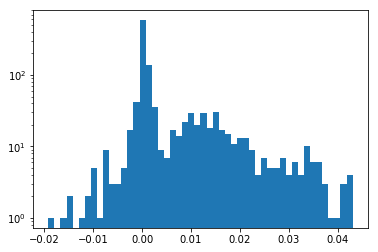

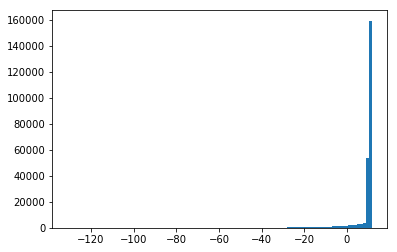

0

In [21]:

os.system("ffmpeg.exe -framerate {} -i {}/figs/slice-%04d.png {}/figs/movie.mp4".format(int(Nz/5.),datafolder,datafolder))

0

[2, 4, 5]

['CS201HBA1', 'RS407HBA', 'CS501HBA1']
Setting refAnt: CS201HBA1


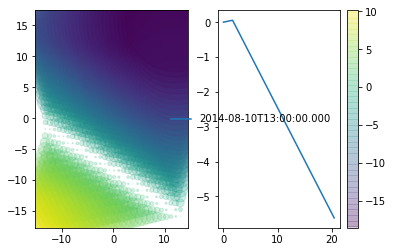

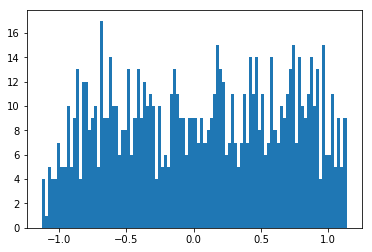

In [24]:

antennas,antennaLabels = dataPack.get_antennas(antIdx = [0,10,43])
print(antennaLabels)
patches, patchNames = dataPack.get_directions(dirIdx=-1)
times,timestamps = dataPack.get_times(timeIdx=[0])
dataPack.setReferenceAntenna(antennaLabels[0])
plotDataPack(dataPack,antIdx=[0,10,43],timeIdx=[0], dirIdx=-1,plotAnt=None)
dtec = dataPack.get_dtec(antIdx=[0,10,43],timeIdx=np.arange(1),dirIdx=-1)
plt.hist(dtec[2,:,:].flatten(),bins=100)
plt.show()
Na = len(antennas)
Nt = len(times)
Nd = len(patches)  
